In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error

import statistics as st
import lightgbm as lgbm
from scipy.stats import norm

In [2]:
sys.path.append('../../')
import src.utils as utils

## Param

In [3]:
EXP_NUM = 43
NFOLDS = 5
SEED = 42

In [4]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight', 'playerForTestSetAndFuturePreds']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
transactions_cols = ['playerId', 'transaction_flag', 'date']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

feature_cols1 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info'] 

feature_cols2 = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info'] 

feature_cols3 = ['week_day','label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info'] 

feature_cols4 = ['week_day', 'annual_day', 'month', 'label_playerId', 'label_primaryPositionName', 'label_teamId', 'label_birthCity',
                'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances',
        "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_skew","target1_kurt",
         "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_skew","target2_kurt",
        "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_skew","target3_kurt",
        "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_skew","target4_kurt", 
        'season_info'] 

In [5]:
# training lightgbm
params1 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 10,
            'min_child_weight': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.7,
            'reg_lambda': 0.006887688001162887,
            'reg_alpha': 0.3246152231343507,
            'feature_fraction': 0.6028124534518233,
            'bagging_fraction': 0.493086136079008,
            'bagging_freq': 2
}


params2 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 11,
            'min_child_weight': 13,
            'subsample': 0.7,
            'colsample_bytree': 0.9,
            'reg_lambda': 32.40220626953001,
            'reg_alpha': 0.38546610508837126,
            'feature_fraction': 0.5300940277454406,
            'bagging_fraction': 0.8569695217087466,
            'bagging_freq': 5
}


params3 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 16,
            'min_child_weight': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'reg_lambda': 3.696374948172724,
            'reg_alpha': 0.12365654015150976,
            'feature_fraction': 0.9499961164257357,
            'bagging_fraction': 0.6038869297109184,
            'bagging_freq': 6
}

params4 = {
            'random_state': SEED,
            'objective':'mae',
            'n_estimators': 10000,
            'learning_rate': 0.1,
            'max_depth': 13,
            'min_child_weight': 18,
            'subsample': 0.8,
            'colsample_bytree': 0.5,
            'reg_lambda': 4.447559791546618,
            'reg_alpha': 26.28386041884225,
            'feature_fraction': 0.7940267398504559,
            'bagging_fraction': 0.7850795571853056,
            'bagging_freq': 5
}

In [6]:
utils.set_seed(SEED)

## Dir

In [7]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [8]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')

# events = pd.read_csv(TRAIN_DIR / 'events_train.csv')
# events = events.groupby(['gameDate']).sum().reset_index()


In [9]:
seasons = seasons.fillna('0000-00-00')
for c_ in seasons.columns[1:]:
    seasons[c_] = seasons[c_].str.replace('-', '').astype(int)

In [10]:
game_dates_range = []
game_dates_range.append(np.array([20170101, 20171231]))
game_dates_range.append(scores[scores['date'] <= 20181231].sort_values('date')['date'].iloc[[0, -1]].values)
game_dates_range.append(scores[(scores['date'] >= 20190101) & (scores['date'] <= 20191231)].sort_values('date')['date'].iloc[[0, -1]].values)
game_dates_range.append(scores[(scores['date'] >= 20200101) & (scores['date'] <= 20201231)].sort_values('date')['date'].iloc[[0, -1]].values)
game_dates_range.append(scores[(scores['date'] >= 20210101)].sort_values('date')['date'].iloc[[0, -1]].values)
game_dates_range = np.array(game_dates_range)

In [11]:
# scores[(scores['date'] >= 20200101) & (scores['date'] <= 20201231)].sort_values('date')

In [12]:
seasons['gameStartDate'] = game_dates_range[:, 0]
seasons['gameEndDate'] = game_dates_range[:, 1]

In [13]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate,gameStartDate,gameEndDate
0,2017,20170402,20171101,20170222,20170401,20170402,20171001,20170709,20170711,20170714,20171003,20171101,20170101,20171231
1,2018,20180329,20181028,20180221,20180327,20180329,20181001,20180715,20180717,20180719,20181002,20181028,20180329,20181028
2,2019,20190320,20191030,20190221,20190326,20190320,20190929,20190707,20190709,20190711,20191001,20191030,20190320,20191030
3,2020,20200723,20201028,20200221,20200722,20200723,20200927,20200825,0,20200826,20200929,20201028,20200723,20201027
4,2021,20210228,20211031,20210228,20210330,20210401,20211003,20210711,20210713,20210715,20211004,20211031,20210401,20210430


In [14]:
targets_train = targets[(targets['date'] >= 20210401)]

In [15]:
targets_train

,engagementMetricsDate,playerId,target1,target2,target3,target4,index,date
2444346,2021-04-02,624415,2.810640,3.998462,0.136137,10.012438,1186,20210401
2444347,2021-04-02,656548,0.000000,0.153787,0.068889,0.062189,1186,20210401
2444348,2021-04-02,400284,0.000971,0.010985,0.021323,3.182007,1186,20210401
2444349,2021-04-02,606157,0.002736,1.642226,0.021323,0.549337,1186,20210401
2444350,2021-04-02,665620,0.020473,0.411929,0.549469,0.435323,1186,20210401
...,...,...,...,...,...,...,...,...
2506171,2021-05-01,451661,0.000000,0.013314,0.000000,0.625925,1215,20210430
2506172,2021-05-01,519301,0.000131,0.003329,0.000000,0.216229,1215,20210430
2506173,2021-05-01,527055,0.000000,0.019971,0.000000,0.273131,1215,20210430
2506174,2021-05-01,543484,0.000131,0.056586,0.000000,1.024240,1215,20210430


In [16]:
playerId_list = targets_train['playerId'].unique()

In [17]:
def calc_corr(df):
    # 相関係数行列を作成
    corr_mat = df.corr(method='pearson')

    # 行（列）サイズを取得
    n = corr_mat.shape[0]
    corr_ary = []

    for i in range(n):
        for j in range(i):
            if i == j:
                continue
            corr_ary.append(corr_mat.iloc[i,j])

    return corr_ary

In [18]:
def calc_probs(pid,df,temp):
    to_append=[pid,'','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    z=1
    for target in targets:
        target_prob = temp[target].tolist()
        mean = np.mean(target_prob)
        std = np.std(target_prob)
        median = st.median(target_prob)
        distribution = norm(mean, std)
        min_weight = min(target_prob)
        max_weight = max(target_prob)
        values = list(np.linspace(min_weight, max_weight))
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value)
        to_append[z]=mean
        to_append[z+1]=median
        to_append[z+2]=std
        to_append[z+3]=min_weight
        to_append[z+4]=max_weight
        to_append[z+5]=target_prob[max_index]
        to_append[z+6]=temp[target].skew()
        to_append[z+7]=temp[target].kurt()

        z=z+8
    corr_ = calc_corr(temp[['target1', 'target2', 'target3', 'target4']])
    to_append[z:] = corr_  
    df_length = len(df)
    df.loc[df_length] = to_append
    return df
    

### CREATE DATAFRAME to store probabilities
column_names = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_prob","target1_skew","target1_kurt",
                "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_prob","target2_skew","target2_kurt",
                "target3_mean","target3_median","target3_std","target3_min","target3_max","target3_prob","target3_skew","target3_kurt",
                "target4_mean","target4_median","target4_std","target4_min","target4_max","target4_prob","target4_skew","target4_kurt",
                'tgt1_2_corr', 'tgt1_3_corr', 'tgt2_3_corr', 'tgt1_4_corr', 'tgt2_4_corr', 'tgt3_4_corr']
player_target_probs = pd.DataFrame(columns = column_names)
    
for pid in tqdm(playerId_list):
    temp = targets_train[targets_train['playerId'] == pid]
    player_target_stats=calc_probs(pid,player_target_probs,temp)

100%|██████████| 2061/2061 [00:45<00:00, 45.02it/s]


In [19]:
player_target_stats

,playerId,target1_mean,target1_median,target1_std,target1_min,target1_max,target1_prob,target1_skew,target1_kurt,target2_mean,...,target4_max,target4_prob,target4_skew,target4_kurt,tgt1_2_corr,tgt1_3_corr,tgt2_3_corr,tgt1_4_corr,tgt2_4_corr,tgt3_4_corr
0,624415.0,1.193031,0.489252,1.578499,0.008327,7.267988,0.785380,2.208850,6.071897,5.398585,...,26.025186,10.464387,1.695464,3.831404,0.408492,-0.009458,-0.101143,0.227373,0.694767,-0.039737
1,656548.0,0.110672,0.001015,0.428984,0.000000,2.392265,0.000000,5.272732,28.385845,0.445853,...,0.423573,0.032978,1.294196,1.140084,0.566411,0.588373,0.527886,0.231260,0.525065,0.132559
2,400284.0,0.001807,0.001301,0.001164,0.000437,0.004770,0.001127,1.155729,0.582752,0.073071,...,8.909871,7.882136,0.388255,-0.703079,0.102451,0.429495,0.046450,0.006606,0.277479,-0.016683
3,606157.0,0.748247,0.024461,1.318711,0.002736,4.840508,0.548613,2.003263,3.235374,2.027612,...,3.931330,0.231750,2.053818,4.653597,0.641382,0.093253,-0.002014,0.404372,0.626199,0.249109
4,665620.0,0.483331,0.020388,1.415708,0.004932,6.322554,0.128698,3.507992,11.893073,1.913634,...,8.474798,0.314951,4.910653,25.637658,0.807310,0.810125,0.965737,0.778467,0.954381,0.959152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,621350.0,0.000020,0.000000,0.000051,0.000000,0.000175,0.000175,2.331868,3.822563,0.007298,...,0.206009,0.017662,0.992179,0.627281,0.278321,NaN,NaN,-0.041837,0.060094,NaN
2057,665759.0,0.000095,0.000000,0.000174,0.000000,0.000701,0.000000,2.033176,3.899046,0.238824,...,0.332631,0.019864,2.366135,7.230272,0.676003,NaN,NaN,0.678376,0.848313,NaN
2058,448178.0,0.000020,0.000000,0.000052,0.000000,0.000174,0.000000,2.345681,3.902834,0.005605,...,0.350299,0.188265,2.416382,8.149779,-0.053275,-0.134373,-0.260662,-0.106479,-0.172380,-0.078929
2059,488681.0,0.000074,0.000000,0.000142,0.000000,0.000506,0.000000,2.153297,3.865929,0.012644,...,0.453328,0.075379,1.055577,1.166366,-0.114731,0.364257,0.095866,0.216720,0.301329,0.054098


In [20]:
data_names=player_target_stats.columns.values.tolist()

In [21]:
players['DOY'] = pd.to_datetime(players['DOB'], format="%Y-%m-%d").dt.year
players['mlbDebutYear'] = pd.to_datetime(players['mlbDebutDate'], format="%Y-%m-%d").dt.year
players['DebutAge'] = players['mlbDebutYear'] - players['DOY']

In [22]:
# creat dataset
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
train = train.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


In [23]:
# label encoding
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
birthCityn2num = {c: i for i, c in enumerate(train['birthCity'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_birthCity'] = train['birthCity'].map(birthCityn2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)

In [24]:
date_ = pd.to_datetime(train['date'], format="%Y%m%d")
train['annual_day'] = (date_ - pd.to_datetime(date_.dt.year, format="%Y")) /  timedelta(days=1)
train['week_day'] = date_.dt.weekday
train['month'] = date_.dt.month
train['year'] = date_.dt.year

In [25]:
train['gameday'] = ~train['battingOrder'].isna()*1

In [26]:
train.sort_values(by=['playerId','date'],inplace=True,ascending=True)

In [27]:
def count_consecutive_items_n_cols(df, col_name_list, output_col):
    cum_sum_list = [
        (df[col_name] != df[col_name].shift(1)).cumsum().tolist() for col_name in col_name_list
    ]
    df[output_col] = df.groupby(
        ["_".join(map(str, x)) for x in zip(*cum_sum_list)]
    ).cumcount() + 1
    return df

In [28]:
train=count_consecutive_items_n_cols(train,['playerId','gameday'],'daysSinceLastGame')
train.loc[train['gameday']==1,'daysSinceLastGame']=0

In [29]:
train_game = train[train['gameday']==1]
train_last_game = train_game[~train_game.duplicated(subset='playerId', keep='last')][['playerId', 'date']]
train_last_game.columns = ['playerId', 'lastdate']
train_player_unique = pd.DataFrame(train['playerId'].unique(), columns=['playerId'])
train_last_game = pd.merge(train_player_unique, train_last_game, on=['playerId'], how='left' )
train_last_game = train_last_game.fillna(20171231)

In [30]:
train_last_game.sort_values('lastdate')

,playerId,lastdate
856,593590,20171231.0
1995,670462,20171231.0
2000,670764,20171231.0
1765,661269,20171231.0
1932,667674,20171231.0
...,...,...
473,542932,20210430.0
1480,641856,20210430.0
1481,641857,20210430.0
483,543037,20210430.0


In [31]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [32]:
on_preseason_idxes = extract_season(train['date'], seasons[['preSeasonStartDate', 'preSeasonEndDate']])
on_season_idxes = extract_season(train['date'], seasons[['regularSeasonStartDate', 'regularSeasonEndDate']]) * 2
on_postseason_idxes = extract_season(train['date'], seasons[['postSeasonStartDate', 'postSeasonEndDate']]) * 3

special_days = seasons['lastDate1stHalf'].to_list() + seasons['allStarDate'].to_list() + seasons['firstDate2ndHalf'].to_list()
special_idxes = 0
for day in special_days:
    special_idxes += (train['date'] == day) * 4

on_total_season_idxes = on_preseason_idxes
on_total_season_idxes[on_season_idxes==2] = 2
on_total_season_idxes[on_postseason_idxes==3] = 3
on_total_season_idxes[special_idxes==4] = 4

train['season_info'] = on_total_season_idxes

In [33]:
train = pd.merge(train, seasons, left_on='year', right_on='seasonId', how='left')
train['seasonDayNum'] = train['seasonEndDate'] - train['date']

In [34]:
## only on season
on_whole_idxes = extract_season(train['date'], seasons[['gameStartDate', 'gameEndDate']])
train = train[on_whole_idxes == 1].reset_index(drop=True)


In [35]:
train = train[train['playerForTestSetAndFuturePreds']==True].reset_index(drop=True)

In [36]:
def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=verbose)
    oof_pred = model.predict(x_valid)
    oof_pred = np.clip(oof_pred, 0, 100)
    score = mean_absolute_error(oof_pred, y_valid)
    print('mae:', score)
    return oof_pred, model, score


In [37]:
train_X = train
train_y = train[['target1', 'target2', 'target3', 'target4']]
tr_idxs = []
val_idxs = []

In [38]:
tr_idx = (train['date'].astype(int) < 20191001)
val_idx = (train['date'].astype(int) >= 20191001) & (train['date'].astype(int) < 20191030)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20200801)
val_idx = (train['date'].astype(int) >= 20200801) & (train['date'].astype(int) < 20200901)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20200901)
val_idx = (train['date'].astype(int) >= 20200901) & (train['date'].astype(int) < 20201001)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

tr_idx = (train['date'].astype(int) < 20201001)
val_idx = (train['date'].astype(int) >= 20201001) & (train['date'].astype(int) < 20201030)
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)



tr_idx = (train['date'].astype(int) < 20210401)
val_idx = ~tr_idx
tr_idxs.append(tr_idx)
val_idxs.append(val_idx)

In [39]:
len(val_idxs[0][val_idxs[0]==True])

34423

In [40]:
model1s = []
model2s = []
model3s = []
model4s = []
oof = np.zeros(train_y.shape) - 1.0
y_valids = np.zeros(train_y.shape) - 1.0
for idx in range(NFOLDS):
    
    tr_idx = tr_idxs[idx]
    val_idx = val_idxs[idx]

    x_train = train_X.loc[tr_idx].reset_index(drop=True)
    y_train = train_y.loc[tr_idx].reset_index(drop=True)
    x_valid = train_X.loc[val_idx].reset_index(drop=True)
    y_valid = train_y.loc[val_idx].reset_index(drop=True)


    oof1, model1, score1 = fit_lgbm(
        x_train[feature_cols1], y_train['target1'],
        x_valid[feature_cols1], y_valid['target1'],
        params1
    )
    oof2, model2, score2 = fit_lgbm(
        x_train[feature_cols2], y_train['target2'],
        x_valid[feature_cols2], y_valid['target2'],
        params2
    )
    oof3, model3, score3 = fit_lgbm(
        x_train[feature_cols3], y_train['target3'],
        x_valid[feature_cols3], y_valid['target3'],
        params3
    )
    oof4, model4, score4 = fit_lgbm(
        x_train[feature_cols4], y_train['target4'],
        x_valid[feature_cols4], y_valid['target4'],
        params4
    )

    score = (score1+score2+score3+score4) / 4
    print(f'score: {score}')
    
    model1s.append(model1)
    model2s.append(model2)
    model3s.append(model3)
    model4s.append(model4)
    oof[val_idx, 0] = oof1
    oof[val_idx, 1] = oof2
    oof[val_idx, 2] = oof3
    oof[val_idx, 3] = oof4
    y_valids[val_idx, 0] = y_valid['target1'].values
    y_valids[val_idx, 1] = y_valid['target2'].values
    y_valids[val_idx, 2] = y_valid['target3'].values
    y_valids[val_idx, 3] = y_valid['target4'].values
    


[LightGBM] [Warning] feature_fraction is set=0.6028124534518233, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.6028124534518233
[LightGBM] [Warning] bagging_fraction is set=0.493086136079008, subsample=0.9 will be ignored. Current value: bagging_fraction=0.493086136079008
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.921918	valid_1's l1: 0.45704
[200]	training's l1: 0.92149	valid_1's l1: 0.456761
[300]	training's l1: 0.921488	valid_1's l1: 0.456763
Early stopping, best iteration is:
[253]	training's l1: 0.921489	valid_1's l1: 0.456761
mae: 0.45674682723036175
[LightGBM] [Warning] feature_fraction is set=0.5300940277454406, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.5300940277454406
[LightGBM] [Warning] bagging_fraction is set=0.8569695217087466, subsample=0.7 will be ignored. Current val

In [41]:
oof_indexes = []
for i in range(NFOLDS):
    oof_indexes.extend(val_idxs[i][val_idxs[i]==True].index.to_list())

In [42]:
y_valids[val_idx, :]
mae = mean_absolute_error(y_valids[oof_indexes, :], oof[oof_indexes, :])
print("mae:", mae)

mae: 1.1572864607700912


In [43]:
oof_df = train[targets_cols]
oof_df.iloc[oof_indexes, 1:5] = oof[oof_indexes, :]

In [44]:
oof_df.iloc[oof_indexes].to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv')

In [45]:
# oof_df.to_csv(OUTPUT_DIR / f'oof{EXP_NUM}.csv', index=False)

In [46]:
models = np.array([model1s, model2s, model3s, model4s])
with open(OUTPUT_DIR / f"models{EXP_NUM}.pickle", mode="wb") as f:
    pickle.dump(models, f)

In [47]:
weights = [0.05, 0.1, 0.15, 0.2, 0.5]

In [48]:
pred1s = 0
pred2s = 0
pred3s = 0
pred4s = 0
for i in range(NFOLDS):
    pred1 = models[0][i].predict(x_valid[feature_cols1])
    pred2 = models[1][i].predict(x_valid[feature_cols2])
    pred3 = models[2][i].predict(x_valid[feature_cols3])
    pred4 = models[3][i].predict(x_valid[feature_cols4])
    oof_valid_april = np.clip(np.array([pred1, pred2, pred3, pred4]).T, 0, 100)
    mae = mean_absolute_error(y_valid, oof_valid_april)
    print("mae:", mae)
    pred1s += pred1 * weights[i]
    pred2s += pred2 * weights[i]
    pred3s += pred3 * weights[i]
    pred4s += pred4 * weights[i]

mae: 1.5466219836802817
mae: 1.541806789479224
mae: 1.540820822838989
mae: 1.5337724704726
mae: 1.5212878458207517


In [49]:
oof_valid_april = np.clip(np.array([pred1s, pred2s, pred3s, pred4s]).T, 0, 100)

In [50]:
# oof_valid_april = np.where(oof_valid_april < 0.1, 0, oof_valid_april)

In [51]:
mae = mean_absolute_error(y_valid, oof_valid_april)
print("mae:", mae)

mae: 1.5252662576355263


In [52]:
0.9089095026960331

0.9089095026960331

## EDA pred

In [48]:
importance = pd.DataFrame(model1.feature_importances_, index=feature_cols1, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[30:30].index

Index([], dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

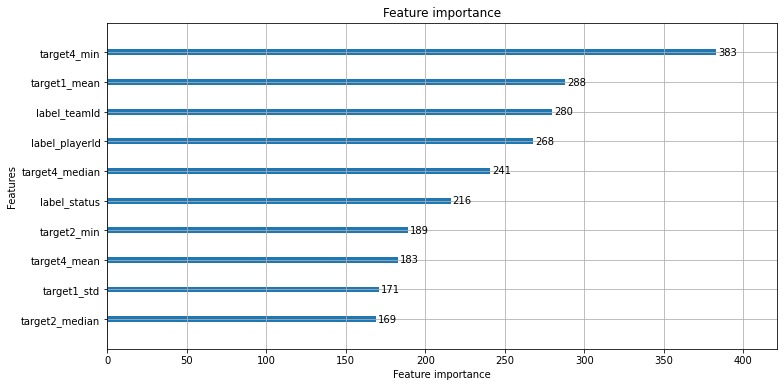

In [52]:
lgbm.plot_importance(model1, figsize=(12, 6), max_num_features=10)

In [50]:
importance = pd.DataFrame(model2.feature_importances_, index=feature_cols2, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['daysSinceLastGame', 'label_teamId', 'season_info', 'label_playerId',
       'target4_min', 'target4_median', 'label_status', 'target2_median',
       'target2_std', 'target2_mean', 'target2_skew', 'target2_min',
       'target1_mean', 'target4_skew', 'target4_kurt', 'target2_kurt',
       'target4_std', 'target1_skew', 'target1_kurt', 'target2_max',
       'target3_kurt', 'target4_mean', 'target4_max', 'target3_skew',
       'target1_std', 'label_primaryPositionName', 'target3_mean',
       'target1_median', 'target3_min', 'target3_std'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

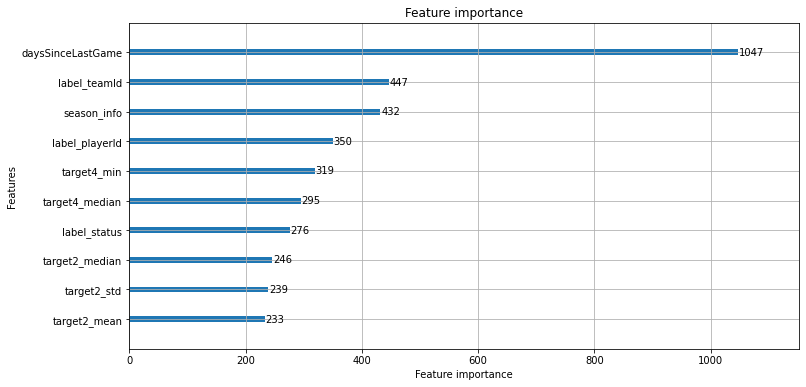

In [51]:
lgbm.plot_importance(model2, figsize=(12, 6), max_num_features=10)

In [52]:
importance = pd.DataFrame(model3.feature_importances_, index=feature_cols3, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['daysSinceLastGame', 'label_teamId', 'target4_min', 'target3_mean',
       'label_playerId', 'target1_kurt', 'target2_mean', 'target4_median',
       'target4_mean', 'label_status', 'target2_skew', 'target2_median',
       'target4_skew', 'target1_mean', 'target1_skew', 'target3_skew',
       'target2_min', 'target4_std', 'target4_kurt', 'target2_std',
       'target2_kurt', 'target2_max', 'target4_max', 'target3_median',
       'target3_kurt', 'target1_median', 'season_info', 'target3_std',
       'target3_min', 'target1_std'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

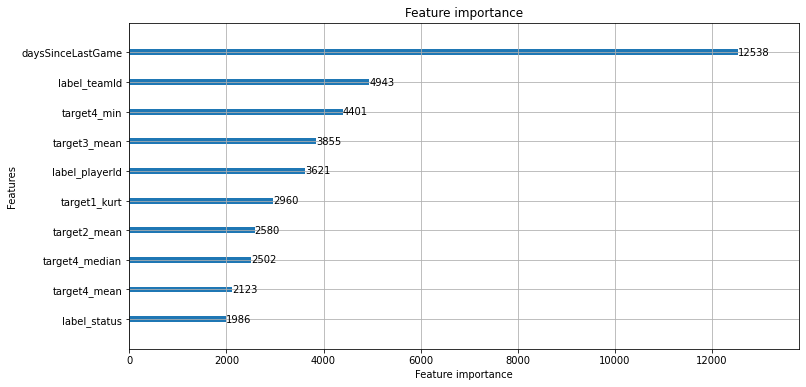

In [53]:
lgbm.plot_importance(model3, figsize=(12, 6), max_num_features=10)

In [54]:
importance = pd.DataFrame(model4.feature_importances_, index=feature_cols4, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
importance.iloc[:30].index

Index(['annual_day', 'daysSinceLastGame', 'target4_min', 'week_day',
       'target4_median', 'mlbDebutYear', 'label_teamId', 'target2_median',
       'season_info', 'label_playerId', 'label_birthCity', 'weight',
       'target4_mean', 'label_status', 'DOY', 'target2_mean', 'target1_skew',
       'target2_min', 'target2_skew', 'target4_skew', 'target2_std',
       'target3_skew', 'target4_std', 'target2_kurt', 'target1_kurt',
       'target3_mean', 'target3_kurt', 'target4_max', 'heightInches',
       'DebutAge'],
      dtype='object')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

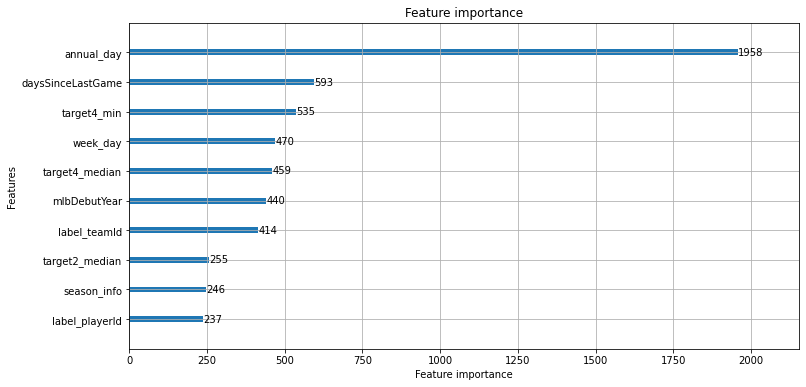

In [55]:
lgbm.plot_importance(model4, figsize=(12, 6), max_num_features=10)

## テストで取ってこれる一行はこんな感じ

In [33]:
example_sample_submission = pd.read_csv(MAIN_DATA_DIR / "example_sample_submission.csv")
example_test = pd.read_csv(MAIN_DATA_DIR / "example_test.csv")
test_df = example_test.set_index('date').iloc[:1]
sample_prediction_df = example_sample_submission[example_sample_submission['date']==test_df.index[0]].set_index('date')

In [34]:
players_cols = ['playerId', 'primaryPositionName', 'birthCity', 'DOY', 'mlbDebutYear', 'DebutAge', 'heightInches', 'weight']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

# env = mlb.make_env() # initialize the environment
# iter_test = env.iter_test() # iterator which loops over each date in test set

# for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
sample_prediction_df = sample_prediction_df.reset_index(drop=True)

# creat dataset
sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                    .map(lambda x: int(x.split('_')[1]))
# Dealing with missing values
if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
    test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
else:
    test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in rosters.columns:
        if col == 'playerId': continue
        test_rosters[col] = np.nan

if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
    test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
else:
    test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
    for col in scores.columns:
        if col == 'playerId': continue
        test_scores[col] = np.nan
test_scores = test_scores.groupby('playerId').sum().reset_index()
test = sample_prediction_df[['playerId']].copy()
test = test.merge(players[players_cols], on='playerId', how='left')
test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
test = test.merge(test_scores[scores_cols], on='playerId', how='left')
test = test.merge(player_target_stats, how='inner', left_on=["playerId"],right_on=["playerId"])


test['label_playerId'] = test['playerId'].map(player2num)
test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
test['label_teamId'] = test['teamId'].map(teamid2num)
test['label_status'] = test['status'].map(status2num)
test['label_birthCity'] = test['birthCity'].map(birthCityn2num)

date_ = pd.to_datetime(test_df.index[0], format="%Y%m%d")
test['annual_day'] = (date_ - pd.to_datetime(date_.year, format="%Y")) /  timedelta(days=1)
test['week_day'] = date_.weekday()
test['month'] = date_.month


test_X = test

In [35]:
test_X['gameday'] = ~test_X['battingOrder'].isna()*1
test_X['date'] = test_df.index[0]
test_X = pd.merge(test_X, train_last_game, on=['playerId'], how='left')
test_X['daysSinceLastGame'] = (pd.to_datetime(test_X['date'], format="%Y%m%d") - pd.to_datetime(test_X['lastdate'], format="%Y%m%d")).dt.days
test_X.loc[test_X['gameday']==1,'daysSinceLastGame']=0

In [59]:
train_last_game = pd.merge(train_last_game, test_X[test_X['gameday']==1][['playerId','date']], on=['playerId'], how='left')
train_last_game['lastdate'].update(train_last_game['date'])
train_last_game = train_last_game[['playerId', 'lastdate']]
train_last_game

,playerId,lastdate
0,112526,20180922.0
1,134181,20180930.0
2,279571,20180930.0
3,282332,20191017.0
4,400085,20190321.0
...,...,...
2056,681911,20210426.0
2057,683232,20210426.0
2058,683734,20210426.0
2059,685493,20200927.0


In [54]:
# predict
pred1 = model1.predict(test_X[feature_cols1])
pred2 = model2.predict(test_X[feature_cols2])
pred3 = model3.predict(test_X[feature_cols3])
pred4 = model4.predict(test_X[feature_cols4])

# merge submission
sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
sample_prediction_df = sample_prediction_df.fillna(0.)

del sample_prediction_df['playerId']

In [55]:
sample_prediction_df

,date_playerId,target1,target2,target3,target4
0,20210427_656669,4.523566,7.302453,2.559227e-01,2.723813
1,20210427_543475,0.147992,3.124557,2.008687e-01,1.193542
2,20210427_592866,0.006262,1.240768,1.289277e-02,1.045266
3,20210427_452678,0.028216,3.628774,4.949686e-02,1.776316
4,20210427_570257,0.008472,1.085709,1.132856e-02,0.437531
...,...,...,...,...,...
1182,20210427_593590,0.000010,0.013661,1.073450e-18,0.000000
1183,20210427_642180,0.002000,1.000161,3.896596e-03,0.397934
1184,20210427_663399,0.000242,0.336076,1.736459e-03,0.087545
1185,20210427_664199,0.000847,0.919104,5.898664e-03,0.507688
